In [1]:
data_file = 'SinPeaksDOWN.xls'

# Figure Info.

| Title | Journal | Authors | Article Date | Code Date | Figure | Links |
|:------|:-------:|:-------:|:------------:|:---------:|:------:|:-----:|
|A microfluidic approach for experimentally modelling <br> the intercellular coupling system of a mammalian <br> circadian clock at single-cell level|Lab on a Chip|Kui Han|2020.03.02|2020.03.11| Fig3F | [DOI](https://doi.org/10.1039/D0LC00140F) |


In [2]:
import os, sys, warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

sns.set_context(context='poster')

bigsize   = 20
midsize   = 18
smallsize = 14
hugesize  = 24

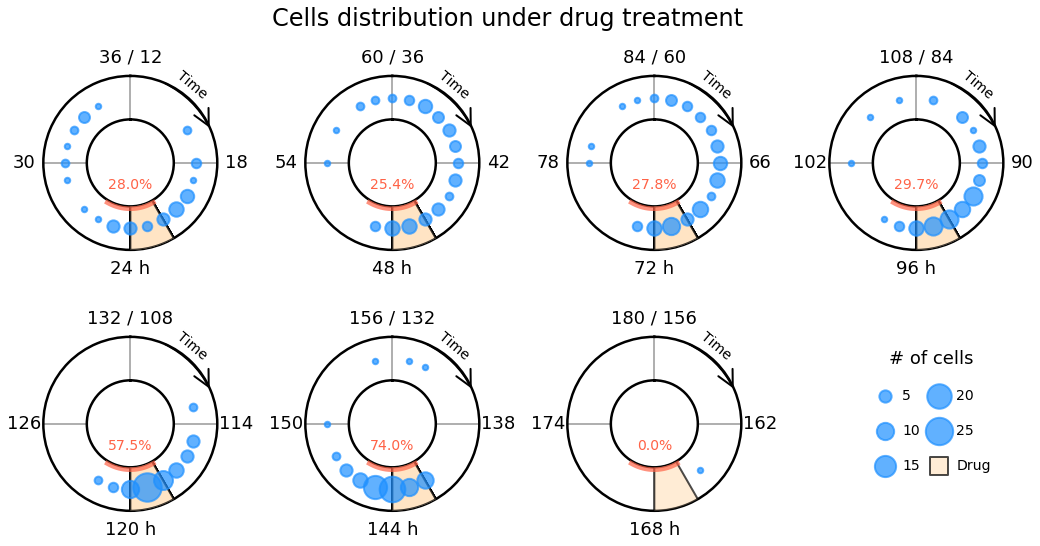

In [3]:
# Load data
new_inputs = pd.read_excel(data_file,header=None)
new_inputs = new_inputs.values.flatten()
new_inputs = new_inputs[~np.isnan(new_inputs)]
new_inputs = pd.Series(new_inputs)

dict_time = new_inputs.astype(int).value_counts()

# Set start and end days
d_min = np.floor( ((new_inputs-12)/24).astype(np.float).min() )
d_min = max(0, d_min)
d_max = np.ceil(  ((new_inputs-12)/24).astype(np.float).max() )

drug_time = 22 + np.arange(0,d_max+1)*24

# Set plot
n_plot = int( d_max - d_min + 1 )
n_rows = int( np.ceil(n_plot/4) )
ratio_dfs_dict = dict(zip(np.arange(n_plot), [pd.DataFrame()]*n_plot))

fig, axs = plt.subplots(
    ncols=4,nrows=n_rows,
    figsize=(18,n_rows*4), 
    subplot_kw={'polar':True}, 
    gridspec_kw={'hspace':0.5},
)
axs = axs.flatten()

# Plot data for each 24h
for i_time in dict_time.keys():
    if i_time<12:
        continue
    d_time = int( np.floor((i_time-12)/24)-d_min )

    # In one day
    ratio_df = ratio_dfs_dict[d_time]
    ratio_df = ratio_df.append(
        {
            'ref_time' : ((i_time-12) % 24),
            'n'        : dict_time[i_time]
        }, ignore_index=True)
    ratio_dfs_dict[d_time] = ratio_df
    
    # Date to r
    t_time = (((i_time-12) % 24)/24)*2*np.pi
    t_drug = ((1+drug_time[d_time]-12)%24)/24*2*np.pi
    axs[d_time].bar(t_drug, 1, width=2/24*2*np.pi, bottom=0.0, color='bisque', edgecolor='k', alpha=0.7, zorder=10)
    axs[d_time].scatter(t_time, 0.5, color='dodgerblue', s=dict_time[i_time]*30, alpha=0.7, zorder=20)

# Plot info for each 24h
for i,ax in enumerate(axs):
    labels = (12+np.arange(24*(d_min+i),24*(d_min+i+1),6)).astype(int).astype(str)
    labels[0] = str( int(labels[0])+24 ) + ' / ' + labels[0]
    labels[2] = labels[2] + ' h'
    
    ax.set_xticklabels( labels, fontsize=midsize )
    ax.set_yticklabels([])
    ax.tick_params(axis='x', pad=0)

    ratio_df = ratio_dfs_dict[i]
    if ratio_df.shape[0]!=0:
        r_df = pd.concat(
            [
                ratio_df['n'], 
                pd.cut(
                    ratio_df['ref_time'], 
                    bins  =[0,   3,  10,  14,  24 ], 
                    labels=[ 'Q1','Q2','Q3','Q4'],
                    include_lowest=True, 
                )
            ], axis=1
        ).groupby('ref_time').sum()
        r = np.round( 100*(r_df.loc['Q3']/r_df.sum())['n'], 1 )
        
        ax.text( 12/24*2*np.pi, -0.5, str(r)+'%', fontsize=smallsize, ha='center', va='center', color='tomato' )
        ax.plot(
            np.linspace(10, 14, 20)/24*2*np.pi,
            [0.05]*20, 
            lw=5, color='tomato',alpha=0.7,
            zorder=20,
        )
        ax.set_thetagrids([0,90,180,270])
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_rgrids([])
        ax.set_rlim(0,1)
        ax.set_rorigin(-1.0)
        ax.annotate(
            s='', 
            xytext=(np.pi/8,1),
            xy=(np.pi*3/8,1),
            size=40,
            arrowprops={
                'facecolor':'black',
                'arrowstyle':'->',
                'connectionstyle':"arc3,rad=-0.17",
            },
        )
        ax.text(np.pi/4,1,'Time',fontsize=smallsize, rotation=-40, ha='center',va='bottom')

    else:
        lgs = []
        for s in np.arange(5,30,5):
            lg = ax.scatter(s, 0.5, color='dodgerblue', s=s*30, alpha=0.7, zorder=1, label=s)
            lgs.append(lg)
        lg = ax.scatter(1,1,marker='s',s=300, color='bisque', edgecolor='k', alpha=0.7, label='Drug')
        lgs.append(lg)
        ax.set_rlim(0,0.1)
        ax.axis('off')
        ax.legend(
            handles=lgs,
            ncol=2,
            title='# of cells',
            title_fontsize=midsize,
            fontsize=smallsize,
            frameon=False,
            labelspacing=1.5,
            handletextpad=0.2,
            columnspacing=0.4,
         )

fig.subplots_adjust(hspace=0.3)
fig.suptitle('Cells distribution under drug treatment', y=1, fontsize=hugesize)

fig.savefig('Clock_Fig3F.svg', transparent=True, bbox_inches='tight')
fig.savefig('Clock_Fig3F.png', transparent=True, bbox_inches='tight')

plt.show()
